In [1]:
import pandas as pd
from hana_ml import dataframe as dfh

In [2]:
hana_cloud_endpoint="8e1a286a-21d7-404d-8d7a-8c77d2a77050.hana.trial-eu10.hanacloud.ondemand.com:443"

In [3]:
hana_cloud_host, hana_cloud_port=hana_cloud_endpoint.split(":")

cchc=dfh.ConnectionContext(port=hana_cloud_port,
                                         address=hana_cloud_host,
                                         user='HANAML',
                                         password='Super$ecr3t!',
                                         encrypt=True
                                        )

In [4]:
cchc.connection.isconnected()

True

In [5]:
dfh_ports=cchc.table("PORTS", geo_cols={"POINT_LON_LAT_GEO":"4326"})
dfh_routes=cchc.table("ROUTES")

## Create SAP HANA graph workspace

In [6]:
import hana_ml.graph.hana_graph

In [7]:
hgws_airroutes = (
    hana_ml.graph.hana_graph
    .create_hana_graph_from_vertex_and_edge_frames(
        connection_context=cchc, 
        workspace_name='AIRROUTES_DFH',
        
        vertices_hdf=dfh_ports,
        vertex_key_column="ID", 
        
        edges_hdf=dfh_routes, 
        edge_key_column="ID",
        edge_source_column="FROM", edge_target_column="TO"
    )
)

In [8]:
print("SQL for Vertices: {}\nSQL for Edges: {}"
      .format(hgws_airroutes.vertices_hdf.select_statement,
              hgws_airroutes.edges_hdf.select_statement))

SQL for Vertices: SELECT * FROM "PORTS_VIEW"
SQL for Edges: SELECT * FROM "ROUTES_VIEW"


## Exploring the graph

### Edges/vertices

In [9]:
hgws_airroutes.vertices_hdf.filter("CODE='WRO'").collect()

,ID,CODE,ICAO,DESC,REGION,RUNWAYS,LONGEST,ELEV,COUNTRY,CITY,LAT,LON,POINT_LON_LAT_GEO
0,313,WRO,EPWR,Copernicus Wroclaw Airport,PL-DS,1,8202,404,PL,Wroclaw,51.102699,16.885799,POINT (16.885799408 51.10269927979999)


In [10]:
hgws_airroutes.vertices(vertex_key=313)

,ID,CODE,ICAO,DESC,REGION,RUNWAYS,LONGEST,ELEV,COUNTRY,CITY,LAT,LON,POINT_LON_LAT_GEO
0,313,WRO,EPWR,Copernicus Wroclaw Airport,PL-DS,1,8202,404,PL,Wroclaw,51.102699,16.885799,POINT (16.885799408 51.10269927979999)


In [11]:
hgws_airroutes.vertices(
    vertex_key=(hgws_airroutes
                .vertices_hdf.filter("CODE='WRO'").select('ID')
                .collect().values[0][0])
)

,ID,CODE,ICAO,DESC,REGION,RUNWAYS,LONGEST,ELEV,COUNTRY,CITY,LAT,LON,POINT_LON_LAT_GEO
0,313,WRO,EPWR,Copernicus Wroclaw Airport,PL-DS,1,8202,404,PL,Wroclaw,51.102699,16.885799,POINT (16.885799408 51.10269927979999)


In [12]:
hgws_airroutes.edges(vertex_key=313).head(3)

,ID,FROM,TO,DIST
0,28373,313,52,373.0
1,28372,313,51,651.0
2,28375,313,70,525.0


In [13]:
hgws_airroutes.edges(vertex_key=313, direction='INCOMING').head(3)

,ID,FROM,TO,DIST
0,10000,52,313,373.0
1,9702,51,313,651.0
2,12606,70,313,525.0


In [14]:
hgws_airroutes.source(edge_key=hgws_airroutes.edges(
    vertex_key=313, 
    direction='INCOMING').head(1).ID.values[0])

,ID,CODE,ICAO,DESC,REGION,RUNWAYS,LONGEST,ELEV,COUNTRY,CITY,LAT,LON,POINT_LON_LAT_GEO
0,52,FRA,EDDF,Frankfurt am Main,DE-HE,4,13123,364,DE,Frankfurt,50.026402,8.54313,POINT (8.54312992096 50.0264015198)


### Neighbors

In [15]:
dfp_nei_wro=hgws_airroutes.neighbors(start_vertex=313)
print("Number of immediate neighbors: {}".format(len(dfp_nei_wro.index)))
display(dfp_nei_wro)

Number of immediate neighbors: 53


,ID
0,2652
1,1735
2,1268
3,1230
4,1196
5,794
6,791
7,787
8,786
9,784


In [16]:
dfp_nei_wro=hgws_airroutes.neighbors(
    start_vertex=313, 
    min_depth=0, 
    include_edges=True
).edges()

display(dfp_nei_wro)

,ID,FROM,TO
0,28424,313,2652
1,28423,313,1735
2,28422,313,1268
3,28421,313,1230
4,28420,313,1196
...,...,...,...
1438,9889,52,76
1439,9887,52,74
1440,9883,52,70
1441,9877,52,60


In [17]:
len(dfp_nei_wro[dfp_nei_wro['FROM']==313].ID)

53

### Visualization of graphs

In [18]:
# Install networkx if needed
!pip install networkx

In [19]:
import matplotlib.pyplot as plt
import networkx as nx
nx.__version__

'2.5'

In [20]:
plt.rcParams["figure.figsize"] = [26, 12]

In [21]:
nx_graph_wro = nx.from_pandas_edgelist(
    dfp_nei_wro, 
    source="FROM", target="TO"
)

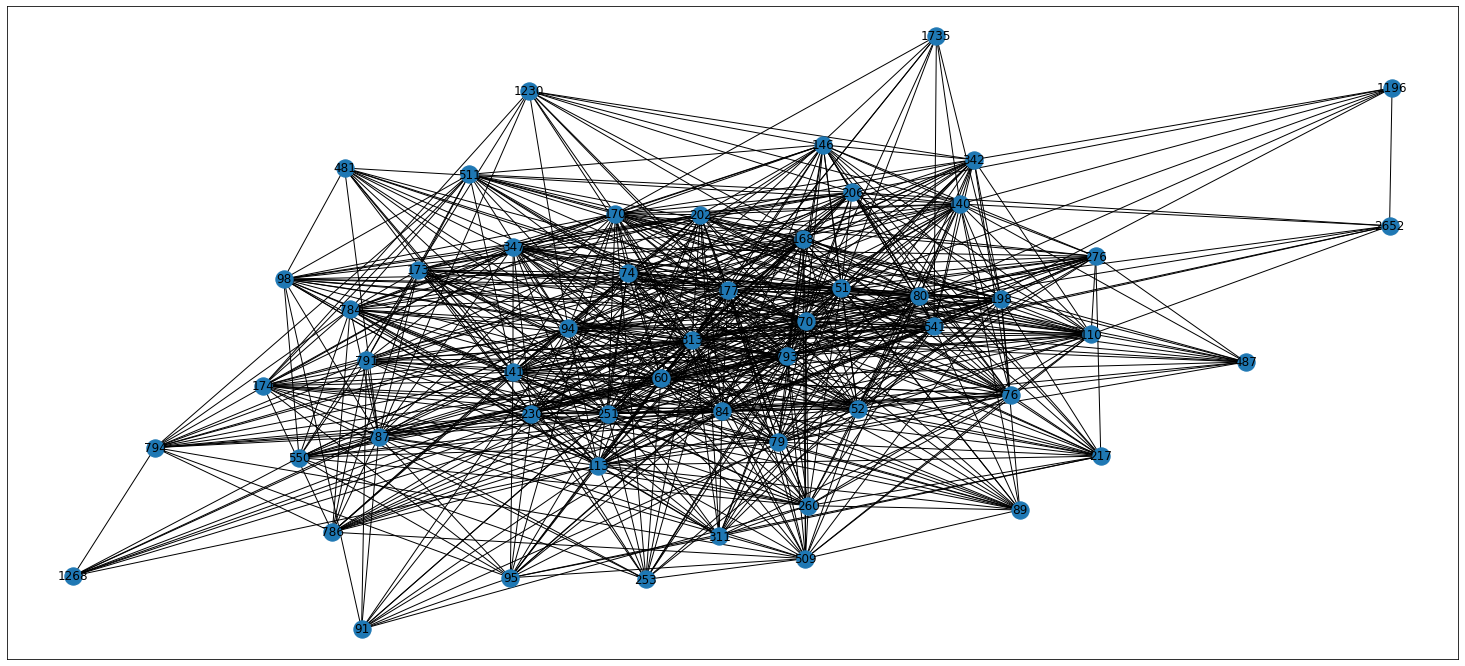

In [22]:
nx.draw_networkx(nx_graph_wro)

In [23]:
nx_graph_wro = nx.from_pandas_edgelist(
    dfp_nei_wro.query("FROM==313"), 
    source="FROM", 
    target="TO"
)

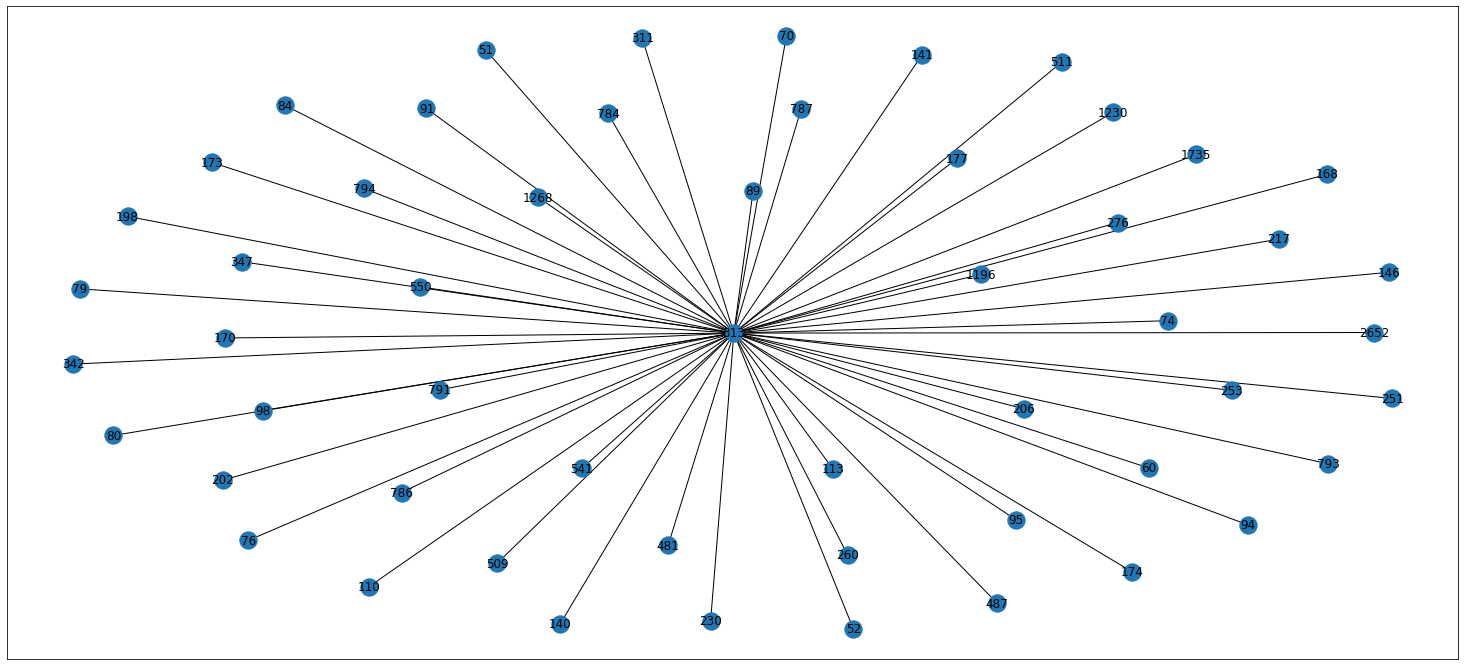

In [24]:
nx.draw_networkx(nx_graph_wro)

In [25]:
pos_geo=nx.shell_layout(nx_graph_wro)

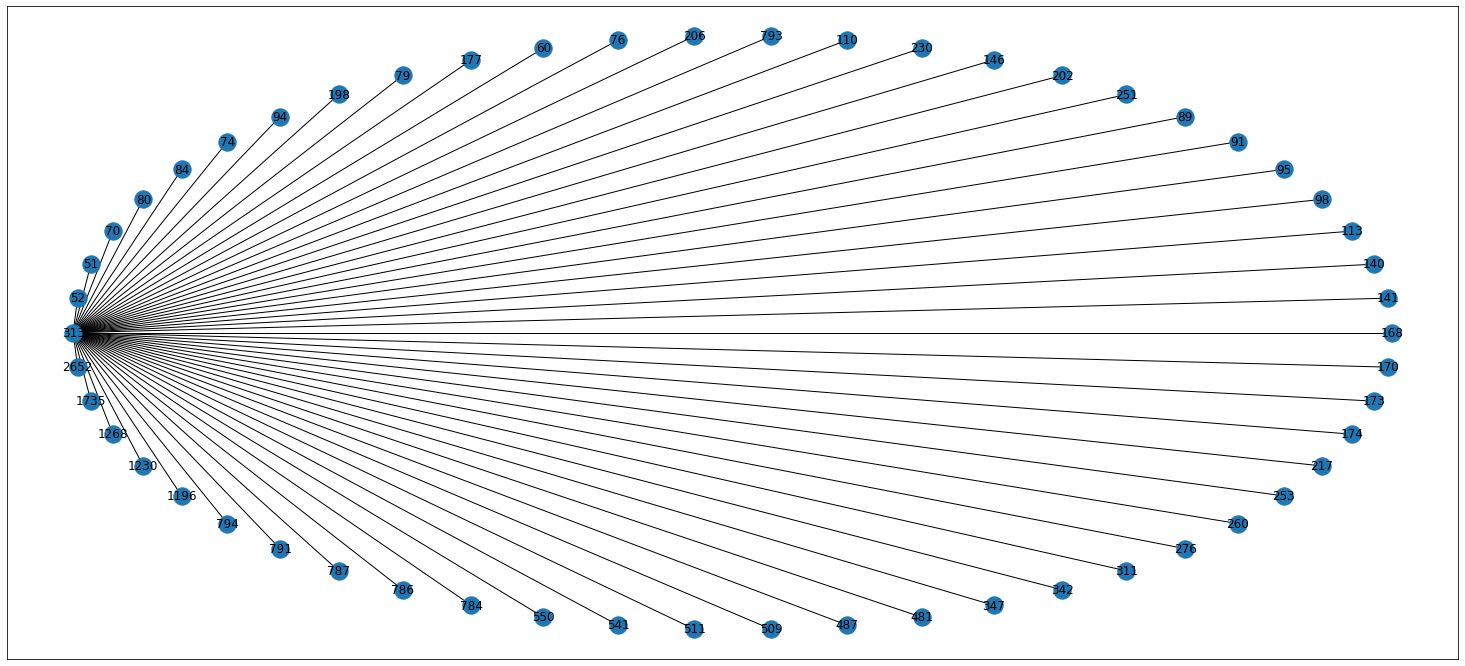

In [26]:
nx.draw_networkx(nx_graph_wro, pos=pos_geo)

In [27]:
hgws_airroutes.vertices(vertex_key=313)[['LON','LAT']].values[0]

array([16.88579941, 51.10269928])

In [28]:
for x in pos_geo.keys():
    pos_geo[x]=hgws_airroutes.vertices(vertex_key=x)[['LON','LAT']].values[0]

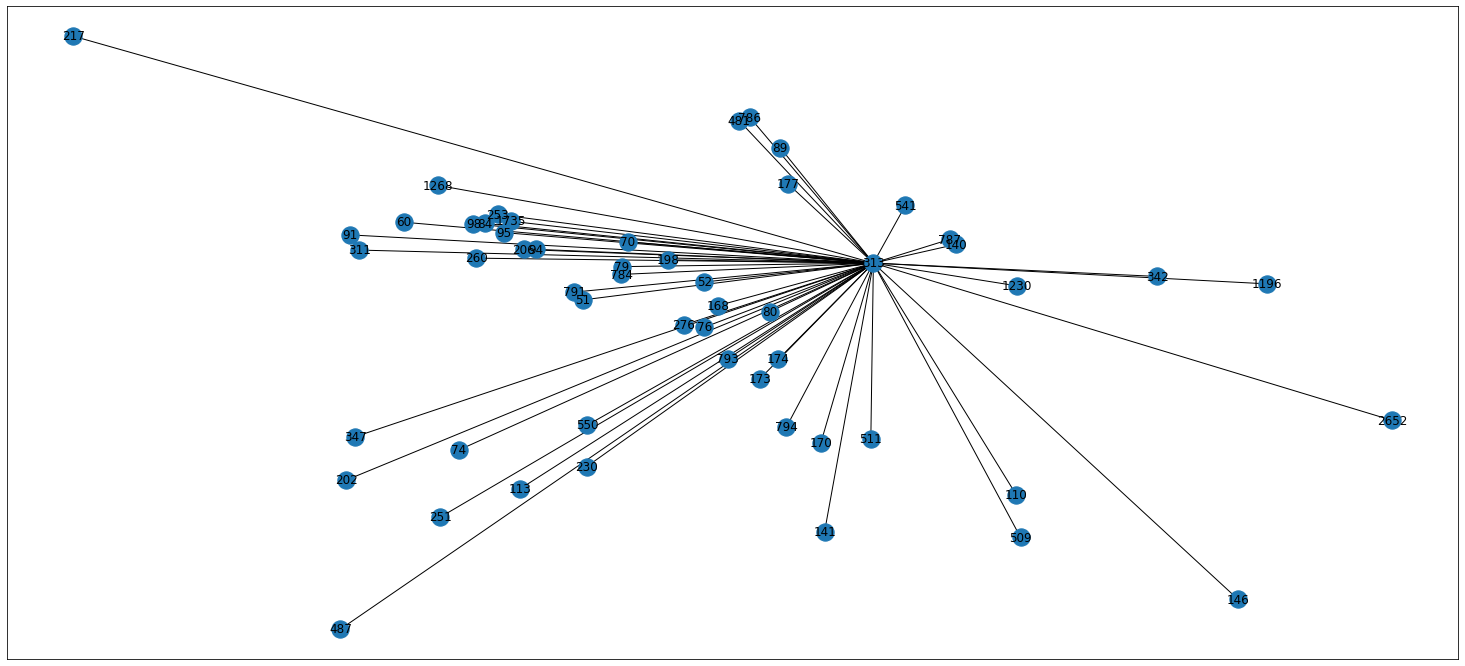

In [29]:
nx.draw_networkx(nx_graph_wro, pos=pos_geo)